# Interrupt

This page considers the ways to implement a temporary interruption to the graph, a typical solution for different human-in-the-loop use cases.

In [1]:
from typing import TypedDict

import langgraph
from langgraph.types import interrupt
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

## Call

One way to implement an interruption in the graph is to call the `langgraph.types.interrupt` funciton in the graph.

---

The following cell implements the `blocking_node` and `next_node` nodes. Both show in stdout that they have been invoked, but the `blocking` node calls the `interrupt` function.

In [2]:
class State(TypedDict):
    messages: list[str]


def blocking_node(state: State) -> State:
    print("Blocking node is called")
    interrupt("Interrupted info")
    return state


def next_node(state: State) -> State:
    print("Next node")
    return state


graph = (
    StateGraph(State)

    .add_node("blocking_node", blocking_node)
    .add_node("next_node", next_node)

    .add_edge(START, "blocking_node")
    .add_edge("blocking_node", "next_node")
    .add_edge("next_node", END)

    .compile()
)

Followign cell calls the graph.

In [8]:
state = graph.invoke(State(messages=["some message"]))
state

Blocking node is called


{'messages': ['some message'],
 '__interrupt__': [Interrupt(value='Interrupted info', id='371869cd206582930df77fbe75f9d90b')]}

As the result there is only a message from the `blocking_node` - the `next_node` was not executed at all due the graph being interrupted. The output state contains the `__interrupt__` attribute with details of the interruption.

## Before/after

At different stages of the graph usage, you can pass a list of node names to the argumetns `interrupt_before` or `interrupt_after` to specify the set of the nodes after which the graph should be interrupted. You can specify this:

- During graph compilation.
- During the invocation of the graph.
- In the call to the langgraph http application.

---

The following cell compiles the graph that is printed when the `interrupt_me` and `next_node` are invoked.

In [40]:
class State(TypedDict):
    messages: list[str]


def interrupt_me(state: State):
    print("Interrupting node")
    return state


def next_node(state: State):
    print("Next node called")
    return state


graph_builder = (
    StateGraph(State)
    .add_node("interrupt_me", interrupt_me)
    .add_node("next_node", next_node)

    .add_edge(START, "interrupt_me")
    .add_edge("interrupt_me", "next_node")
    .add_edge("interrupt_me", END)
)

The following cell compiles the graph with the parameter `interrupt_after=["interrupt_me"]` and displays it:

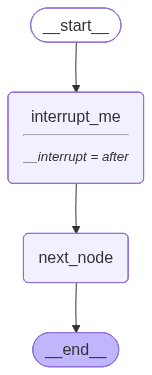

In [41]:
graph = graph_builder.compile(
    interrupt_after=["interrupt_me"]
)
graph

Next code invokes the graph.

In [42]:
state = graph.invoke(State(messages=["Initial message"]))
state

Interrupting node


{'messages': ['Initial message']}

The main feature is that the message from the `interrupt_me` node is printed, but the flow doesn't proceed to the subsequent steps. 

The following cell illustrates an alternative approach: it specifies the `interrupt_before` during the invocation of the graph.

In [43]:
graph = graph_builder.compile()
graph.invoke(
    State(messages=["Hello world"]),
    interrupt_before=["next_node"]
)

Interrupting node


{'messages': ['Hello world']}

## Next node

The checkpointer stores information about each thread. In particular, you can retrieve the information about a stopped graph from the state snapshot, which accessable via the graph's `get_state` method of the graph. The `next` attribute contains the information about the next node to be executed.

---

The following cell invokes the graph which will be interrupted.

In [27]:
class State(TypedDict):
    pass


def node(state: State) -> State:
    interrupt("hello")
    return state


graph = (
    StateGraph(State)
    .add_node("node", node)
    .add_edge(START, "node")
    .add_edge("node", END)
    .compile(checkpointer=MemorySaver())
)

configuration = {"configurable": {"thread_id": "1"}}
graph.invoke(State(), configuration)

{'__interrupt__': [Interrupt(value='hello', id='a21abd2361562e72ae52dc3d4d8adcf6')]}

The next line retrieves the information about the node at which the execution will resume.

In [29]:
graph.get_state(configuration).next

('node',)

## Continue execution

The main purpose of the `interrupt` is `langgraph` is to build human in the loop applications: in which user can provide additional information to the LLM based application during the application execution.

To do that you have too:

- Add memory to your graph.
- The `interrupt` invocation returns to the graph information provided from the flow outside the graph.
- To resume the execution, invoke graph again with `langgraph.types.Command` providing additional information via the `resume` argument.

---

The following cell defines the graph in which a single node calls `interupt` and publishes the result to the `State`.

In [12]:
class State(TypedDict):
    message_from_user: str | None


def node(state: State) -> State:
    ans = interrupt("Expecting input")
    return State(message_from_user=ans)


graph = (
    StateGraph(State)
    .add_node("a", node)
    .add_edge(START, "a")
    .add_edge("a", END)
    .compile(checkpointer=MemorySaver())
)

The `config` of the graph invocation is important here as it specifies which thread was interrupted.

In [13]:
config = {"configurable": {"thread_id": 1}}

ans = graph.invoke(
    State(message_from_user=None),
    config=config
)
ans

{'message_from_user': None,
 '__interrupt__': [Interrupt(value='Expecting input', id='100936f7c7bb3c64d03ee1b8833dc950')]}

The graph is interrupted. The next cell shows the how to resume the execution and provide the information to the graph.

In [6]:
graph.invoke(
    langgraph.types.Command(resume="This is input from user"),
    config=config
)

{'message_from_user': 'This is input from user'}

In [11]:
graph.invoke(
    State(message_from_user="Initial message"),
    config=config
)
graph.invoke(None, config=config)

{'message_from_user': 'Initial message',
 '__interrupt__': [Interrupt(value='Expecting input', id='de94044533a66c5a9b557e850e330069')]}

## Update state

The `update_state` method of the graph allows you to set the new state of an interrupted graph, which is useful in situations involving interactions.

---

The following cell defines the graph with interruption.

In [36]:
def node(state: dict) -> dict:
    ans = interrupt("Expecting input")
    return dict(message_from_user=ans)


graph = (
    StateGraph(dict)
    .add_node("a", node)
    .add_edge(START, "a")
    .add_edge("a", END)
    .compile(checkpointer=MemorySaver())
)

Invoking the graph results in the relevant interruption.

In [31]:
config = {"configurable": {"thread_id": 1}}
graph.invoke(
    dict(meesage_from_user="Message 1"),
    config=config
)

{'meesage_from_user': 'Message 1'}

The following cell demonstrates the use of the `update_state` method and the continuation of the graph, which returns graph's updated state.

In [27]:
graph.update_state(
    values={"message_from_user": "Updated message"},
    config=config
)
graph.invoke(None, config=config)

{'message_from_user': 'Updated message',
 '__interrupt__': [Interrupt(value='Expecting input', id='b92971c4e381a1d476450fc87cc71733')]}

## Replay

To replay a garaph, pass the configuration of the state you want the replay to start from to the `invoke` or `stream` method of the graph.

---

The following cell creates a graph produces a different result each time.

In [24]:
import random


def node(state: dict) -> dict:
    return {"value": random.random()}


graph = (
    StateGraph(dict)
    .add_node("node", node)
    .add_edge(START, "node")
    .add_edge("node", END)
    .compile(checkpointer=MemorySaver())
)

config = {"configurable": {"thread_id": 1}}
graph.invoke({}, config=config)

{'value': 0.9661160294695101}

The following cell retrieves some state information from the thread's history.

In [25]:
to_replay = list(graph.get_state_history(config))[0]

Invoking the graph with config from the selected state leads to the same result because it is not a reinvocation of the graph; it is a replay of a thread that has already been executed.

In [26]:
graph.invoke(None, config=to_replay.config)

{'value': 0.9661160294695101}